In [1]:
import pandas as pd, numpy as np
import ppscore as pps
import seaborn as sns
pd.set_option('display.max_columns', None)

## Exploratory Data Analysis

In [2]:
# read in training & test datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

In [4]:
# it appears there are no missing variables
# target variable is Cover_Type
y = train.Cover_Type
train.head(5)

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                6279                 1                 0   
1                                6225                 1                 0   
2                                6121                 1                 0   
3                                6211                 1                 0   
4                                6172                 1                 0   

   Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            1            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  \
0            0            0            0            0            1   
1            0            0            0            0            1  

<AxesSubplot:title={'center':'PPS matrix'}, xlabel='feature', ylabel='target'>

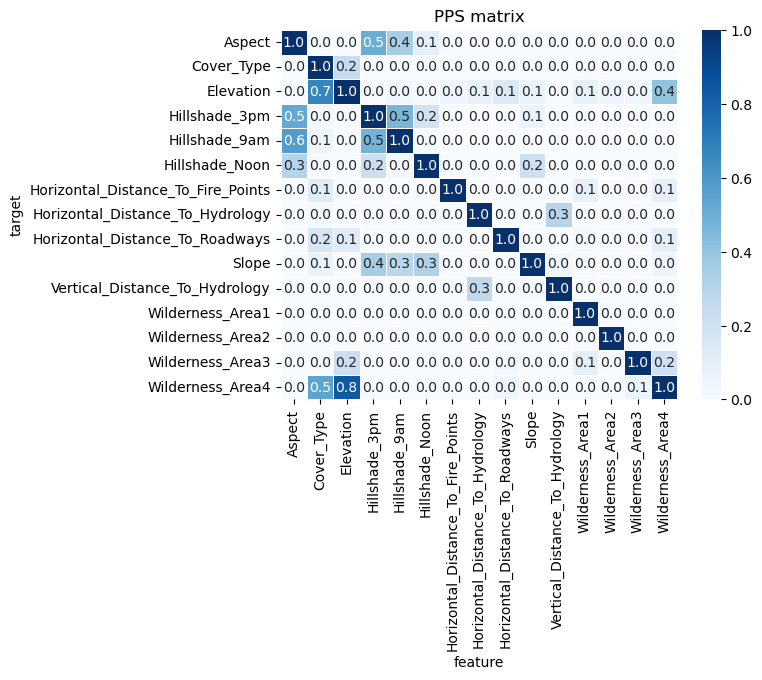

In [5]:
soil_cols = list(train.filter(regex = 'Soil_Type').columns.values)
wild_cols = list(train.filter(regex = 'Wilderness_Area').columns.values)
drop_cols = soil_cols + ['Id']
pps_matrix = pps.matrix(train.drop(columns = drop_cols))

def heatmap(df):
    ppscores = df[["x", "y", "ppscore"]].pivot(columns="x", index="y", values="ppscore")
    ax = sns.heatmap(ppscores, 
                     vmin=0, 
                     vmax=1, 
                     cmap="Blues", 
                     linewidths=0.5, 
                     annot=True,
                     fmt = '.1f'
                    )
    ax.set_title('PPS matrix')
    ax.set_xlabel('feature')
    ax.set_ylabel('target')
    return ax

heatmap(pps_matrix)

### Observations
- Elevation is predictive of wilderness_area4
- covertype is predictive of elevation though the inverse is not true, one way relationship!
- not very helpful as covertype is out target variable

In [6]:
# Wilderness_Area and Soil_Type are one hot encoded, let's revert the encoding
def unencode_soil_wild(df):
    df['soil_type'] = 0
    for i in range(1,41):
        df['soil_type'] = df['soil_type'] + i*df[f"Soil_Type{i}"]
    df['wilderness_area'] = 0
    for i in range(1,5):
        df['wilderness_area'] = df['wilderness_area'] + i*df[f"Wilderness_Area{i}"]
    return df

In [7]:
# create full dataset with train and test to fit standardscaler
train = unencode_soil_wild(train)
test = unencode_soil_wild(test)

not_features = soil_cols + ['Id','Cover_Type'] + wild_cols
features = [
    f for f in train.columns if f not in (
        not_features
    )
]

full_data = pd.concat(
        [train[features], test[features]],
        axis = 0
    )

In [10]:
# pipeline to scale numerical values
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

full_pipeline  = ColumnTransformer([
    # ('num',SimpleImputer(missing_values=np.nan, strategy='mean'),features)
    ('num',StandardScaler(),features),
])

full_pipeline.fit(full_data)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Elevation', 'Aspect', 'Slope',
                                  'Horizontal_Distance_To_Hydrology',
                                  'Vertical_Distance_To_Hydrology',
                                  'Horizontal_Distance_To_Roadways',
                                  'Hillshade_9am', 'Hillshade_Noon',
                                  'Hillshade_3pm',
                                  'Horizontal_Distance_To_Fire_Points',
                                  'soil_type', 'wilderness_area'])])

In [11]:
x_train = full_pipeline.transform(train[features])
x_test = full_pipeline.transform(test[features])

In [12]:
from sklearn import metrics
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

In [13]:
full_data

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0            2596      51      3                               258   
1            2590      56      2                               212   
2            2804     139      9                               268   
3            2785     155     18                               242   
4            2595      45      2                               153   
...           ...     ...    ...                               ...   
565887       2396     153     20                                85   
565888       2391     152     19                                67   
565889       2386     159     17                                60   
565890       2384     170     15                                60   
565891       2383     165     13                                60   

        Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                    0                              510   
1                                   -6                              390   
2                                   65                             3180   
3                                  118                             3090   
4                                   -1                              391   
...                                ...                              ...   
565887                              17                              108   
565888                              12                               95   
565889                               7                               90   
565890                               5                               90   
565891                               4                               67   

        Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0                 221             232            148   
1                 220             235            151   
2                 234             238            135   
3                 238             238            122   
4                 220             234            150   
...               ...             ...            ...   
565887            240             237            118   
565888            240             237            119   
565889            236             241            130   
565890            230             245            143   
565891            231             244            141   

        Horizontal_Distance_To_Fire_Points  soil_type  wilderness_area  
0                                     6279         29                1  
1                                     6225         29                1  
2                                     6121         12                1  
3                                     6211         30                1  
4                                     6172         29                1  
...                                    ...        ...              ...  
565887                                 837          2                3  
565888                                 845          2                3  
565889                                 854          2                3  
565890                                 864          2                3  
565891                                 875          2                3  

[581012 rows x 12 columns]

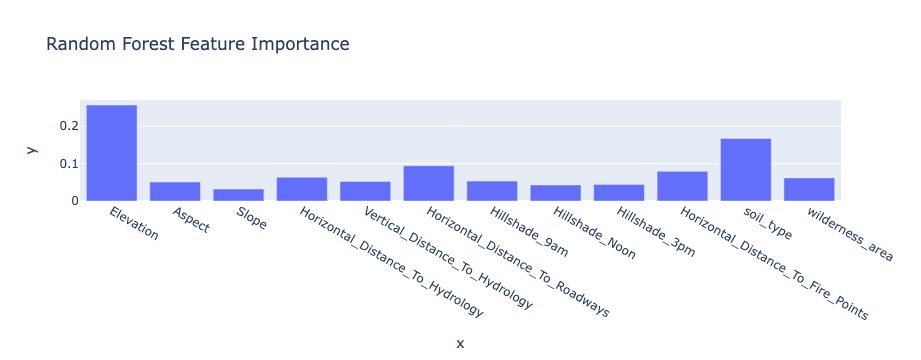

In [14]:
# examine feature importance
model = ensemble.RandomForestClassifier(n_jobs=-1,n_estimators=180)
model.fit(x_train,y)
model.feature_importances_

import plotly.express as px
fig = px.bar(x = train[features].columns,
             y = model.feature_importances_,
             title = "Random Forest Feature Importance")
fig.show()

### Observations
- Elevation and soil_type appear to be the most important
- Horizontal_distance_to_fire_points and _to_roadways and _to_hydrology also appear to be significant
- will plot some relationships and determine whether transformations or combinations are reasonable

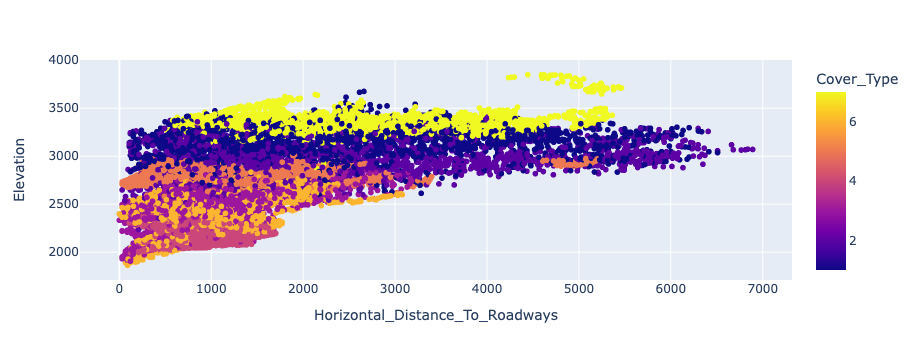

In [36]:
px.scatter(train, y= 'Elevation', x = 'Horizontal_Distance_To_Roadways', color = 'Cover_Type')

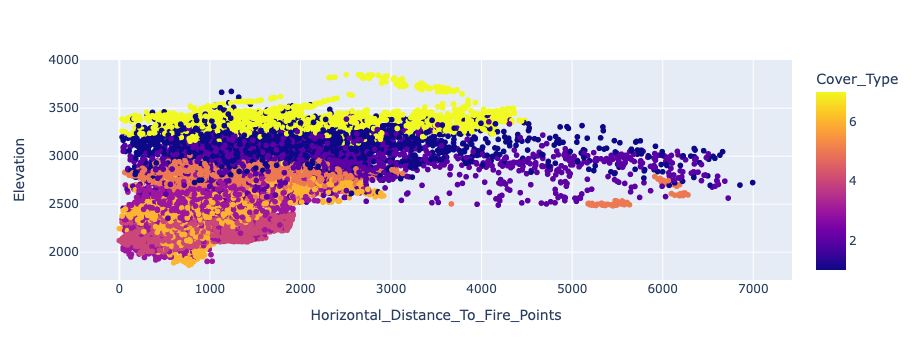

In [37]:
px.scatter(train, y= 'Elevation', x = 'Horizontal_Distance_To_Fire_Points', color = 'Cover_Type')

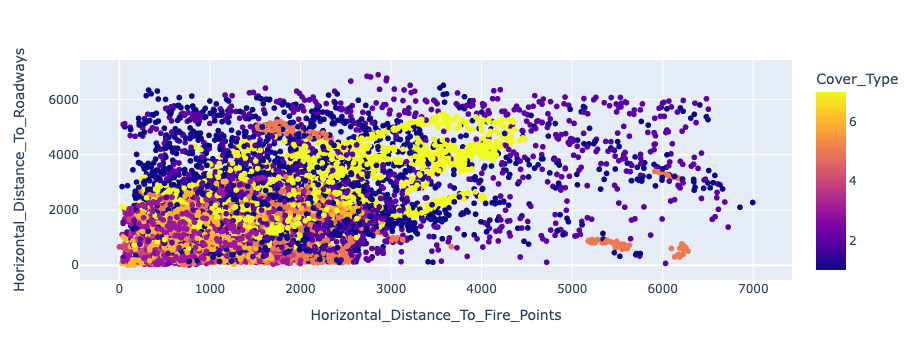

In [38]:
px.scatter(train, 
           y = 'Horizontal_Distance_To_Roadways', 
           x = 'Horizontal_Distance_To_Fire_Points', 
           color = 'Cover_Type')

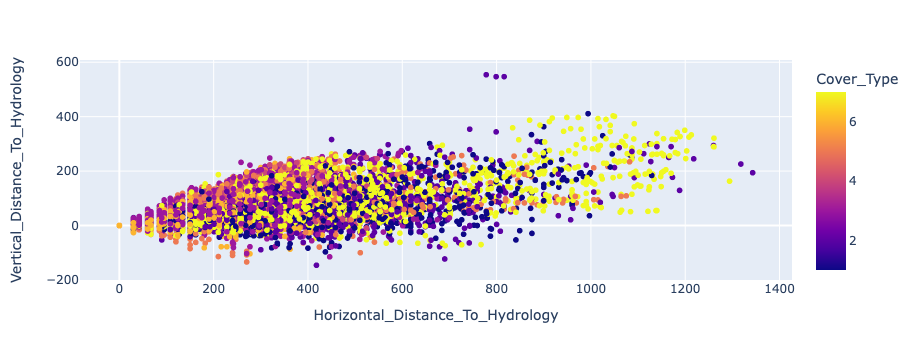

In [39]:
px.scatter(train, 
           x = 'Horizontal_Distance_To_Hydrology', 
           y = 'Vertical_Distance_To_Hydrology', 
           color = 'Cover_Type')

### Observations
- Cover Types certainly vary with elevation
- Certain Cover Types are influenced by proximity to roadways and fire points 

## Modelling

In [16]:
model = ensemble.RandomForestClassifier(n_jobs = -1)
param_grid = {
    'n_estimators':list(range(10,201,5)),
    # 'max_depth':list(range(1,50,1))
}
rf_grid = GridSearchCV(estimator = model, param_grid = param_grid)
rf_grid.fit(x_train,y)
rf_preds = rf_grid.predict(x_train)
print(metrics.classification_report(y,rf_preds))
print(rf_grid.best_params_)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2160
           2       1.00      1.00      1.00      2160
           3       1.00      1.00      1.00      2160
           4       1.00      1.00      1.00      2160
           5       1.00      1.00      1.00      2160
           6       1.00      1.00      1.00      2160
           7       1.00      1.00      1.00      2160

    accuracy                           1.00     15120
   macro avg       1.00      1.00      1.00     15120
weighted avg       1.00      1.00      1.00     15120

{'n_estimators': 160}


In [73]:
rf_test_preds = rf_grid.predict(x_test)
sub_rf = pd.DataFrame({
    'Id':test.Id,
    'Cover_Type':rf_test_preds
})
sub_rf.to_csv('submissions/rf_submission.csv',
              index = False)

In [74]:
from sklearn.ensemble import ExtraTreesClassifier
model = ensemble.ExtraTreesClassifier(n_jobs = -1)
param_grid = {
    'n_estimators':list(range(10,201,5)),
    # 'max_depth':list(range(1,50,1))
}
et_grid = GridSearchCV(estimator = model, param_grid = param_grid)
et_grid.fit(x_train,y)
et_preds = et_grid.predict(x_train)
print(metrics.classification_report(y,rf_preds))
print(et_grid.best_params_)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2160
           2       1.00      1.00      1.00      2160
           3       1.00      1.00      1.00      2160
           4       1.00      1.00      1.00      2160
           5       1.00      1.00      1.00      2160
           6       1.00      1.00      1.00      2160
           7       1.00      1.00      1.00      2160

    accuracy                           1.00     15120
   macro avg       1.00      1.00      1.00     15120
weighted avg       1.00      1.00      1.00     15120

{'n_estimators': 165}


In [75]:
et_test_preds = et_grid.predict(x_test)
sub_et = pd.DataFrame({
    'Id':test.Id,
    'Cover_Type':et_test_preds
})
sub_et.to_csv('submissions/et_submission.csv',
              index = False)

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
model = ensemble.GradientBoostingClassifier()
param_grid = {
    'n_estimators':list(range(10,501,10)),
    # 'max_depth':list(range(1,50,1))
}
grad_grid = GridSearchCV(estimator = model, param_grid = param_grid)
grad_grid.fit(x_train,y)
grad_preds = grad_grid.predict(x_train)
print(metrics.classification_report(y,rf_preds))
print(grad_grid.best_params_)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2160
           2       1.00      1.00      1.00      2160
           3       1.00      1.00      1.00      2160
           4       1.00      1.00      1.00      2160
           5       1.00      1.00      1.00      2160
           6       1.00      1.00      1.00      2160
           7       1.00      1.00      1.00      2160

    accuracy                           1.00     15120
   macro avg       1.00      1.00      1.00     15120
weighted avg       1.00      1.00      1.00     15120

{'n_estimators': 500}


In [34]:
grad_test_preds = grad_grid.predict(x_test)
sub_grad = pd.DataFrame({
    'Id':test.Id,
    'Cover_Type':grad_test_preds
})
sub_grad.to_csv('submissions/grad_submission.csv',
              index = False)

In [44]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors':list(range(1,500,5))
}
knn_grid = GridSearchCV(estimator = knn, param_grid = param_grid)
knn_grid.fit(x_train, y)
knn_preds = knn_grid.predict(x_train)
print(metrics.classification_report(y,knn_preds))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2160
           2       1.00      1.00      1.00      2160
           3       1.00      1.00      1.00      2160
           4       1.00      1.00      1.00      2160
           5       1.00      1.00      1.00      2160
           6       1.00      1.00      1.00      2160
           7       1.00      1.00      1.00      2160

    accuracy                           1.00     15120
   macro avg       1.00      1.00      1.00     15120
weighted avg       1.00      1.00      1.00     15120



In [45]:
knn_test_preds = knn_grid.predict(x_test)
sub_knn = pd.DataFrame({
    'Id':test.Id,
    'Cover_Type':knn_test_preds
})
sub_knn.to_csv('submissions/knn_submission.csv',
              index = False)

In [37]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_jobs = -1,
    booster = 'gbtree',
    use_label_encoder = False
)
param_grid = {
    "max_depth": list(range(1,15,1)),
    "n_estimators":list(range(10,201,10))
}
xgb_grid = GridSearchCV(estimator = model, param_grid = param_grid)
xgb_grid.fit(x_train,(y-1),eval_metric='auc')
xgb_preds = xgb_grid.predict(x_train)
print(metrics.classification_report((y-1),xgb_preds))
print(xgb_grid.best_params_)

/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2160
           1       1.00      1.00      1.00      2160
           2       1.00      1.00      1.00      2160
           3       1.00      1.00      1.00      2160
           4       1.00      1.00      1.00      2160
           5       1.00      1.00      1.00      2160
           6       1.00      1.00      1.00      2160

    accuracy                           1.00     15120
   macro avg       1.00      1.00      1.00     15120
weighted avg       1.00      1.00      1.00     15120

{'max_depth': 12, 'n_estimators': 90}


In [38]:
xgb_test_preds = xgb_grid.predict(x_test)
sub_xgb = pd.DataFrame({
    'Id':test.Id,
    'Cover_Type':(xgb_test_preds + 1)
})
sub_xgb.to_csv('submissions/xgb_submission.csv',
              index = False)

In [39]:
from sklearn.svm import SVC

model = SVC()
param_grid = {
    "kernel": ["linear","rbf"],
    "C":[0.1,1,10]
}
svc_grid = GridSearchCV(estimator = model, param_grid = param_grid)
svc_grid.fit(x_train,y)
svm_preds = svc_grid.predict(x_train)
print(metrics.classification_report(y,svm_preds))

              precision    recall  f1-score   support

           1       0.78      0.78      0.78      2160
           2       0.79      0.67      0.73      2160
           3       0.78      0.72      0.75      2160
           4       0.88      0.97      0.92      2160
           5       0.85      0.91      0.88      2160
           6       0.76      0.78      0.77      2160
           7       0.93      0.96      0.95      2160

    accuracy                           0.83     15120
   macro avg       0.82      0.83      0.82     15120
weighted avg       0.82      0.83      0.82     15120



In [40]:
svm_test_preds = svc_grid.predict(x_test)
sub_svm = pd.DataFrame({
    'Id':test.Id,
    'Cover_Type':svm_test_preds
})
sub_svm.to_csv('submissions/svm_submission.csv',
              index = False)

In [41]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                   hidden_layer_sizes=(5, 2), random_state=1)
nn.fit(x_train,y)
nn_preds = nn.predict(x_train)
print(metrics.classification_report(y,nn_preds))

              precision    recall  f1-score   support

           1       0.54      0.59      0.56      2160
           2       0.50      0.24      0.32      2160
           3       0.54      0.30      0.38      2160
           4       0.73      0.90      0.81      2160
           5       0.60      0.80      0.68      2160
           6       0.46      0.49      0.47      2160
           7       0.73      0.91      0.81      2160

    accuracy                           0.60     15120
   macro avg       0.59      0.60      0.58     15120
weighted avg       0.59      0.60      0.58     15120



/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [42]:
nn_test_preds = nn.predict(x_test)
sub_nn = pd.DataFrame({
    'Id':test.Id,
    'Cover_Type':nn_test_preds
})
sub_nn.to_csv('submissions/nn_submission.csv',
              index = False)

In [43]:
model = SVC(probability = True)
param_grid = {
    "kernel": ["linear","rbf"],
    "C":[0.1,1,10]
}
svc_grid = GridSearchCV(estimator = model, param_grid = param_grid)
from sklearn.ensemble import VotingClassifier 
est_ensemble = VotingClassifier(estimators=[
    #('nn', nn),
    # ('lr', lr_model), 
    ('xgb', xgb_grid),
    ('rf', rf_grid),
    # ('knn', knn_grid),
    # ('svc', svc_grid)
],
                                voting='soft',
                                weights=[1,1])
est_ensemble

VotingClassifier(estimators=[('xgb',
                              GridSearchCV(estimator=XGBClassifier(base_score=None,
                                                                   booster='gbtree',
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   enable_categorical=False,
                                                                   gamma=None,
                                                                   gpu_id=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   min_child_weight=None,
                                                                   mis...
                                                                   verbosity=None),
                                           param_grid={'max_depth': [1, 2, 3, 4,
                                                                     5, 6, 7, 8,
                                                                     9, 10, 11,
                                                                     12, 13,
                                                                     14],
                                                       'n_estimators': [10, 20,
                                                                        30, 40,
                                                                        50, 60,
                                                                        70, 80,
                                                                        90, 100,
                                                                        110,
                                                                        120,
                                                                        130,
                                                                        140,
                                                                        150,
                                                                        160,
                                                                        170,
                                                                        180,
                                                                        190,
                                                                        200]})),
                             ('rf',
                              GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                                           param_grid={'n_estimators': [10, 20,
                                                                        30, 40,
                                                                        50, 60,
                                                                        70, 80,
                                                                        90, 100,
                                                                        110,
                                                                        120,
                                                                        130,
                                                                        140,
                                                                        150,
                                                                        160,
                        

In [ ]:
est_ensemble.fit(x_train,y)
ens_pred = est_ensemble.predict(x_train)

In [45]:
ens_test_preds = est_ensemble.predict(x_test)
sub_ens = pd.DataFrame({
    'Id':test.Id,
    'Cover_Type':ens_test_preds
})
sub_ens.to_csv('submissions/ens_submission.csv',
              index = False)

### Try creating higher order features

In [19]:
# Generate higher order features
from sklearn.preprocessing import PolynomialFeatures

def create_higher_order(df):
    pf = PolynomialFeatures(
        degree = 2, 
        interaction_only = False,
        include_bias = False)
    pf.fit(df)
    poly_features = pf.transform(df)
    num_feats = poly_features.shape[1]
    df_transformed = pd.DataFrame(
        poly_features,
        columns = [f"f_{i}" for i in range(1, num_feats + 1)]
    )
    return df_transformed

In [20]:
# create full dataset with train and test to fit standardscaler
train = unencode_soil_wild(train)
test = unencode_soil_wild(test)

high_order_train = create_higher_order(train[features])
high_order_test = create_higher_order(test[features])
not_features = soil_cols + ['Id','Cover_Type'] + wild_cols

full_data = pd.concat(
        [high_order_train, high_order_test],
        axis = 0
    )

In [21]:
not_features = soil_cols + ['Id','Cover_Type'] + wild_cols
high_order_features = [
    f for f in full_data.columns if f not in (
        not_features
    )
]

In [22]:
# pipeline to scale numerical values
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

full_pipeline  = ColumnTransformer([
    ('num',SimpleImputer(missing_values=np.nan, strategy='mean'),high_order_features)
    # ('num',StandardScaler(),high_order_features),
])

full_pipeline.fit(full_data)

ColumnTransformer(transformers=[('num', SimpleImputer(),
                                 ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6',
                                  'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12',
                                  'f_13', 'f_14', 'f_15', 'f_16', 'f_17',
                                  'f_18', 'f_19', 'f_20', 'f_21', 'f_22',
                                  'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
                                  'f_28', 'f_29', 'f_30', ...])])

In [23]:
x_train = full_pipeline.transform(high_order_train[high_order_features])
x_test = full_pipeline.transform(high_order_test[high_order_features])

In [24]:
# extra trees classifier was our best model previously
# we will stick with it
model = ensemble.ExtraTreesClassifier(n_jobs = -1)
param_grid = {
    'n_estimators':list(range(1700,1725,25)),
    # 'max_depth':list(range(1,50,3))
}
et_grid = GridSearchCV(estimator = model, param_grid = param_grid)
et_grid.fit(x_train,y)
et_preds = et_grid.predict(x_train)
print(metrics.classification_report(y,rf_preds))
print(et_grid.best_params_)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2160
           2       1.00      1.00      1.00      2160
           3       1.00      1.00      1.00      2160
           4       1.00      1.00      1.00      2160
           5       1.00      1.00      1.00      2160
           6       1.00      1.00      1.00      2160
           7       1.00      1.00      1.00      2160

    accuracy                           1.00     15120
   macro avg       1.00      1.00      1.00     15120
weighted avg       1.00      1.00      1.00     15120

{'n_estimators': 1700}


In [25]:
et_test_preds = et_grid.predict(x_test)
sub_et = pd.DataFrame({
    'Id':test.Id,
    'Cover_Type':et_test_preds
})
sub_et.to_csv('submissions/et_poly_submission.csv',
              index = False)